In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil
import re

CONV_DROPOUT_P = 0.6
FC_DROPOUT_P = 0.6
OBJECTIVE_NAME = 'voice_cmd'

def make_identifier_regex(name):
    return f"(?P<{name}>[a-zA-Z0-9\-\_]+)"


def make_number_regex(name):
    return f"(?P<{name}>[0-9\.]+)"



RESULT_FILE_REGEX = re.compile(
    f"{make_identifier_regex('model_name')}__c_dropout_p_{CONV_DROPOUT_P}__f_dropout_p_{FC_DROPOUT_P}__feature_{make_identifier_regex('feature_name')}__fold_id_{make_number_regex('fold_id')}__obj_{OBJECTIVE_NAME}"
)

model_names = [
    #"VAASRCNN1",
    #"VAASRCNN2",
    "VAASRCNN3",
]


DATA_DIR = "results_102/"


random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4", "#2ca02c"]

n = 0
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for result_path in Path(DATA_DIR).iterdir():
    
    match = RESULT_FILE_REGEX.match(result_path.stem)
    if not match:
        print(f"ignoring result file: {result_path}")
        continue
    
    trial_params = match.groupdict()
    
    model_name = trial_params['model_name']
    feature_name = trial_params['feature_name']
    fold_id = int(trial_params['fold_id'])
    
        
    fold_names = []
    
    if not model_name in data_frames:
        data_frames[model_name] = {}
        
    
    fold_name = f"{feature_name}_{fold_id}"
    data_frames[model_name][fold_name] = pd.read_csv(result_path)
    variable_names.extend(list(data_frames[model_name][fold_name].columns))
    
    
    
    #for p in Path(model_path).iterdir():
    #    if not p.suffixes or p.suffixes[-1] != '.csv':
    #        continue
    #    fold_name = p.stem
    #    fold_names.append(fold_name)
    #    data_frames[model_name][fold_name] = pd.read_csv(p)
    #    variable_names.extend(list(data_frames[model_name][p.stem].columns))
    #for fold_name in sorted(fold_names):
    #    print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
    
for m in data_frames.keys():
    print(f"Model: {m}")
    for f in sorted(data_frames[m].keys()):
        print(f"\tfold: {f}")
        
    

ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.7__f_dropout_p_0.7__feature_wav2vec_features-c__fold_id_1__obj_voice_cmd.csv
ignoring result file: results_102/train_va_asr_2020-09-01T14:31:00.591839_pid_3879.log
ignoring result file: results_102/VAASRCNN1__c_dropout_p_0.5__f_dropout_p_0.5__feature_wav2vec_features-z__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.5__f_dropout_p_0.5__feature_retrained-wav2vec_features-c__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.6__f_dropout_p_0.7__feature_mel_spectrogram__fold_id_0__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.5__f_dropout_p_0.6__feature_mel_spectrogram__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/train_va_asr_2020-08-31T23:59:29.678068_pid_51131.log
ignoring result file: results_102/VAASRCNN2__c_dropout_p_0.5__f_dropout_p_0.5__feature_retrained-wav2vec_features-c__fold_id_2__obj_voice_cmd

ignoring result file: results_102/VAASRCNN1__c_dropout_p_0.5__f_dropout_p_0.5__feature_wav2vec_features-z__fold_id_4__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.5__f_dropout_p_0.7__feature_mel_spectrogram__fold_id_0__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN1__c_dropout_p_0.5__f_dropout_p_0.5__feature_wav2vec_features-c__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.7__f_dropout_p_0.7__feature_wav2vec_features-z__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/train_va_asr_2020-08-28T20:22:25.657639_pid_11823.log
ignoring result file: results_102/VAASRCNN1__c_dropout_p_0.5__f_dropout_p_0.5__feature_retrained-wav2vec_features-c__fold_id_2__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.7__f_dropout_p_0.7__feature_retrained-wav2vec_features-z__fold_id_1__obj_voice_cmd.csv
ignoring result file: results_102/VAASRCNN3__c_dropout_p_0.5__f_dropout_p_0.5__

In [3]:
def get_variable_stats_delete_me(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum, sample_size
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    sample_size = len(selected_dfs)
    print(f"fold count: {sample_size}")
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max,
        
        'fold_count': sample_size
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable):
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle='-', label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, plotted_variables, compared_features):

    plot_width = len(model_names)*10
    plot_height = len(plotted_variables)*10
    fig, axes = plt.subplots(len(plotted_variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(plotted_variables), len(model_names))
    for variable_index, variable in enumerate(plotted_variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable
            )

In [7]:
plotted_variables = [
    'train_loss',
    'test_loss',
    'train_acc',
    'test_acc',
    'train_acc_lng',
    
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    
    
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    'test_acc_spoken_in_mothertongue__True',
    
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',

]


additional_plotted_summary_variables = [
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    'spacer',
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'spacer',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    'spacer',
    'test_acc_spoken_in_mothertongue__True',
    'spacer',
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',
]

# Language classification with context features

In [8]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, plotted_variables, compared_features)

In [9]:
data_frames[model_name].keys()

dict_keys(['wav2vec_features-c_0', 'wav2vec_features-c_3', 'retrained-wav2vec_features-z_3', 'retrained-wav2vec_features-c_0', 'mel_spectrogram_2', 'mel_spectrogram_0', 'retrained-wav2vec_features-c_1', 'wav2vec_features-c_4', 'mel_spectrogram_1', 'wav2vec_features-z_0', 'wav2vec_features-z_2', 'retrained-wav2vec_features-z_2', 'wav2vec_features-z_1', 'retrained-wav2vec_features-c_4', 'wav2vec_features-z_3', 'retrained-wav2vec_features-z_1', 'retrained-wav2vec_features-c_2', 'wav2vec_features-c_2', 'retrained-wav2vec_features-z_4', 'retrained-wav2vec_features-z_0', 'wav2vec_features-c_1', 'retrained-wav2vec_features-c_3', 'wav2vec_features-z_4'])

# Language Classification With Latent Features

fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3


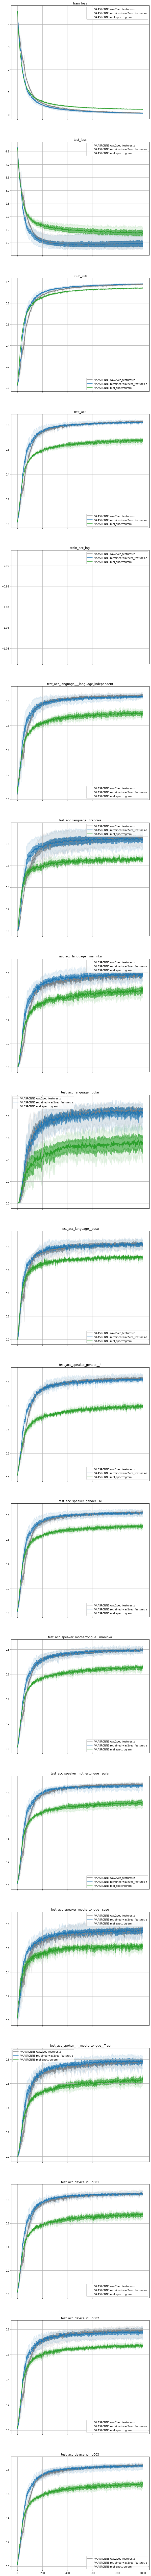

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z', 'mel_spectrogram']
plot_results(model_names, plotted_variables, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
additional_plotted_summary_variables

['test_acc_language___language_independent',
 'test_acc_language__francais',
 'test_acc_language__maninka',
 'test_acc_language__pular',
 'test_acc_language__susu',
 'spacer',
 'test_acc_speaker_gender__F',
 'test_acc_speaker_gender__M',
 'spacer',
 'test_acc_speaker_mothertongue__maninka',
 'test_acc_speaker_mothertongue__pular',
 'test_acc_speaker_mothertongue__susu',
 'spacer',
 'test_acc_spoken_in_mothertongue__True',
 'spacer',
 'test_acc_device_id__d001',
 'test_acc_device_id__d002',
 'test_acc_device_id__d003']

In [13]:
def plot_summary_results(model_names, plotted_variables, compared_features):
    
    count_variables = [v.replace("test_acc_", "test_n_") for v in plotted_variables if v != "spacer"]
    requested_variables = list((set(plotted_variables + count_variables)))
    
    series_means = {v:[] for v in requested_variables}
    series_sems = {v:[] for v in requested_variables}
    series_mins = {v:[] for v in requested_variables}
    series_maxes = {v:[] for v in requested_variables}
    
    series_labels = {v:[] for v in requested_variables}
    fold_counts = []
    
    
    
    
    for variable in requested_variables:
        for feature_prefix in compared_features:
            
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
                fold_counts.append(stats['fold_count'])
    
    # assert len(set(fold_counts)) == 1,  f"Inconsistent number of folds for model_names: {model_names}, features: {compared_features}: {fold_counts}"
    
    
    fold_count = fold_counts[0]
    
    for v in plotted_variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 18))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 21
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    y_bias = {}
    
    y_pos = 3
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable == 'spacer':
            y_pos += .5
        else:
            y_pos += 1.1
            y_bias[bias_variable] = (bar_width+bar_margin)*np.arange(label_count) + y_pos

    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable != 'spacer':
            ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
        
        
    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        for bias_variable in additional_plotted_summary_variables:
            if bias_variable != 'spacer':
                ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
                bias_count_variable = bias_variable.replace("test_acc_", "test_n_")
                ax.text(0.01, y_bias[bias_variable][i]-0.3, f"{bias_variable} ({series_means[bias_count_variable][i]})", color='black', fontsize="small")

        
        ax.legend(["TRAIN", "TEST", "BIAS"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n={fold_count} folds) Speech Recognition Accuracies. Conv Dropout p={CONV_DROPOUT_P}. FC Dropout p={FC_DROPOUT_P}")
        ax.grid(True)

        

fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold c

,train_loss_labels,train_loss_means,train_loss_sems
0,BSLN Latent - VAASRCNN3,0.086927,0.010967
1,OUR Latent - VAASRCNN3,0.075140,0.008749
2,mel_spectrogram - VAASRCNN3,0.238559,0.010589


,test_loss_labels,test_loss_means,test_loss_sems
0,BSLN Latent - VAASRCNN3,0.937956,0.117262
1,OUR Latent - VAASRCNN3,0.942497,0.110162
2,mel_spectrogram - VAASRCNN3,1.353576,0.099713


,train_acc_labels,train_acc_means,train_acc_sems
0,BSLN Latent - VAASRCNN3,0.976797,0.002864
1,OUR Latent - VAASRCNN3,0.980180,0.002279
2,mel_spectrogram - VAASRCNN3,0.945002,0.002713


,test_acc_labels,test_acc_means,test_acc_sems
0,BSLN Latent - VAASRCNN3,0.834809,0.002730
1,OUR Latent - VAASRCNN3,0.830393,0.003459
2,mel_spectrogram - VAASRCNN3,0.685585,0.012183


,train_acc_lng_labels,train_acc_lng_means,train_acc_lng_sems
0,BSLN Latent - VAASRCNN3,-1.0,0.0
1,OUR Latent - VAASRCNN3,-1.0,0.0
2,mel_spectrogram - VAASRCNN3,-1.0,0.0


,test_acc_language___language_independent_labels,test_acc_language___language_independent_means,test_acc_language___language_independent_sems
0,BSLN Latent - VAASRCNN3,0.850099,0.005131
1,OUR Latent - VAASRCNN3,0.839209,0.005448
2,mel_spectrogram - VAASRCNN3,0.710397,0.015705


,test_acc_language__francais_labels,test_acc_language__francais_means,test_acc_language__francais_sems
0,BSLN Latent - VAASRCNN3,0.857667,0.025648
1,OUR Latent - VAASRCNN3,0.847916,0.023540
2,mel_spectrogram - VAASRCNN3,0.670520,0.011557


,test_acc_language__maninka_labels,test_acc_language__maninka_means,test_acc_language__maninka_sems
0,BSLN Latent - VAASRCNN3,0.795952,0.010061
1,OUR Latent - VAASRCNN3,0.793337,0.016653
2,mel_spectrogram - VAASRCNN3,0.662377,0.023419


,test_acc_language__pular_labels,test_acc_language__pular_means,test_acc_language__pular_sems
0,BSLN Latent - VAASRCNN3,0.850567,0.026720
1,OUR Latent - VAASRCNN3,0.849358,0.027917
2,mel_spectrogram - VAASRCNN3,0.549961,0.074730


,test_acc_language__susu_labels,test_acc_language__susu_means,test_acc_language__susu_sems
0,BSLN Latent - VAASRCNN3,0.829521,0.012262
1,OUR Latent - VAASRCNN3,0.837543,0.008718
2,mel_spectrogram - VAASRCNN3,0.724695,0.001859


,test_acc_speaker_gender__F_labels,test_acc_speaker_gender__F_means,test_acc_speaker_gender__F_sems
0,BSLN Latent - VAASRCNN3,0.843253,0.005736
1,OUR Latent - VAASRCNN3,0.831722,0.011216
2,mel_spectrogram - VAASRCNN3,0.605548,0.007739


,test_acc_speaker_gender__M_labels,test_acc_speaker_gender__M_means,test_acc_speaker_gender__M_sems
0,BSLN Latent - VAASRCNN3,0.830051,0.005614
1,OUR Latent - VAASRCNN3,0.827943,0.008622
2,mel_spectrogram - VAASRCNN3,0.721416,0.012899


,test_acc_speaker_mothertongue__maninka_labels,test_acc_speaker_mothertongue__maninka_means,test_acc_speaker_mothertongue__maninka_sems
0,BSLN Latent - VAASRCNN3,0.803704,0.008031
1,OUR Latent - VAASRCNN3,0.806361,0.008803
2,mel_spectrogram - VAASRCNN3,0.669645,0.011684


,test_acc_speaker_mothertongue__pular_labels,test_acc_speaker_mothertongue__pular_means,test_acc_speaker_mothertongue__pular_sems
0,BSLN Latent - VAASRCNN3,0.884841,0.004951
1,OUR Latent - VAASRCNN3,0.872782,0.007902
2,mel_spectrogram - VAASRCNN3,0.722754,0.018812


,test_acc_speaker_mothertongue__susu_labels,test_acc_speaker_mothertongue__susu_means,test_acc_speaker_mothertongue__susu_sems
0,BSLN Latent - VAASRCNN3,0.754706,0.020114
1,OUR Latent - VAASRCNN3,0.753855,0.016713
2,mel_spectrogram - VAASRCNN3,0.622233,0.017065


,test_acc_spoken_in_mothertongue__True_labels,test_acc_spoken_in_mothertongue__True_means,test_acc_spoken_in_mothertongue__True_sems
0,BSLN Latent - VAASRCNN3,0.790125,0.012636
1,OUR Latent - VAASRCNN3,0.795087,0.018104
2,mel_spectrogram - VAASRCNN3,0.634438,0.016006


,test_acc_device_id__d001_labels,test_acc_device_id__d001_means,test_acc_device_id__d001_sems
0,BSLN Latent - VAASRCNN3,0.860390,0.006246
1,OUR Latent - VAASRCNN3,0.860547,0.005404
2,mel_spectrogram - VAASRCNN3,0.684008,0.015795


,test_acc_device_id__d002_labels,test_acc_device_id__d002_means,test_acc_device_id__d002_sems
0,BSLN Latent - VAASRCNN3,0.800473,0.014720
1,OUR Latent - VAASRCNN3,0.790900,0.013658
2,mel_spectrogram - VAASRCNN3,0.683406,0.008101


,test_acc_device_id__d003_labels,test_acc_device_id__d003_means,test_acc_device_id__d003_sems
0,BSLN Latent - VAASRCNN3,0.843563,0.005721
1,OUR Latent - VAASRCNN3,0.839731,0.007524
2,mel_spectrogram - VAASRCNN3,0.689341,0.016711


fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold count: 3
fold count: 5
fold count: 5
fold c

,train_loss_labels,train_loss_means,train_loss_sems
0,BSLN Context - VAASRCNN3,0.044887,0.009780
1,OUR Context - VAASRCNN3,0.066110,0.008415
2,mel_spectrogram - VAASRCNN3,0.238559,0.010589


,test_loss_labels,test_loss_means,test_loss_sems
0,BSLN Context - VAASRCNN3,0.955419,0.154554
1,OUR Context - VAASRCNN3,1.003387,0.129707
2,mel_spectrogram - VAASRCNN3,1.353576,0.099713


,train_acc_labels,train_acc_means,train_acc_sems
0,BSLN Context - VAASRCNN3,0.987848,0.002985
1,OUR Context - VAASRCNN3,0.982006,0.002468
2,mel_spectrogram - VAASRCNN3,0.945002,0.002713


,test_acc_labels,test_acc_means,test_acc_sems
0,BSLN Context - VAASRCNN3,0.845268,0.006028
1,OUR Context - VAASRCNN3,0.823173,0.006485
2,mel_spectrogram - VAASRCNN3,0.685585,0.012183


,train_acc_lng_labels,train_acc_lng_means,train_acc_lng_sems
0,BSLN Context - VAASRCNN3,-1.0,0.0
1,OUR Context - VAASRCNN3,-1.0,0.0
2,mel_spectrogram - VAASRCNN3,-1.0,0.0


,test_acc_language___language_independent_labels,test_acc_language___language_independent_means,test_acc_language___language_independent_sems
0,BSLN Context - VAASRCNN3,0.853096,0.007054
1,OUR Context - VAASRCNN3,0.825503,0.010618
2,mel_spectrogram - VAASRCNN3,0.710397,0.015705


,test_acc_language__francais_labels,test_acc_language__francais_means,test_acc_language__francais_sems
0,BSLN Context - VAASRCNN3,0.873620,0.016751
1,OUR Context - VAASRCNN3,0.855036,0.019001
2,mel_spectrogram - VAASRCNN3,0.670520,0.011557


,test_acc_language__maninka_labels,test_acc_language__maninka_means,test_acc_language__maninka_sems
0,BSLN Context - VAASRCNN3,0.800869,0.013190
1,OUR Context - VAASRCNN3,0.805889,0.013115
2,mel_spectrogram - VAASRCNN3,0.662377,0.023419


,test_acc_language__pular_labels,test_acc_language__pular_means,test_acc_language__pular_sems
0,BSLN Context - VAASRCNN3,0.853866,0.019448
1,OUR Context - VAASRCNN3,0.786712,0.048042
2,mel_spectrogram - VAASRCNN3,0.549961,0.074730


,test_acc_language__susu_labels,test_acc_language__susu_means,test_acc_language__susu_sems
0,BSLN Context - VAASRCNN3,0.849386,0.008683
1,OUR Context - VAASRCNN3,0.827008,0.010724
2,mel_spectrogram - VAASRCNN3,0.724695,0.001859


,test_acc_speaker_gender__F_labels,test_acc_speaker_gender__F_means,test_acc_speaker_gender__F_sems
0,BSLN Context - VAASRCNN3,0.850186,0.007978
1,OUR Context - VAASRCNN3,0.814761,0.003449
2,mel_spectrogram - VAASRCNN3,0.605548,0.007739


,test_acc_speaker_gender__M_labels,test_acc_speaker_gender__M_means,test_acc_speaker_gender__M_sems
0,BSLN Context - VAASRCNN3,0.842757,0.010592
1,OUR Context - VAASRCNN3,0.826466,0.010360
2,mel_spectrogram - VAASRCNN3,0.721416,0.012899


,test_acc_speaker_mothertongue__maninka_labels,test_acc_speaker_mothertongue__maninka_means,test_acc_speaker_mothertongue__maninka_sems
0,BSLN Context - VAASRCNN3,0.823950,0.009049
1,OUR Context - VAASRCNN3,0.805869,0.009396
2,mel_spectrogram - VAASRCNN3,0.669645,0.011684


,test_acc_speaker_mothertongue__pular_labels,test_acc_speaker_mothertongue__pular_means,test_acc_speaker_mothertongue__pular_sems
0,BSLN Context - VAASRCNN3,0.882595,0.008112
1,OUR Context - VAASRCNN3,0.858493,0.007424
2,mel_spectrogram - VAASRCNN3,0.722754,0.018812


,test_acc_speaker_mothertongue__susu_labels,test_acc_speaker_mothertongue__susu_means,test_acc_speaker_mothertongue__susu_sems
0,BSLN Context - VAASRCNN3,0.780543,0.020687
1,OUR Context - VAASRCNN3,0.743127,0.020813
2,mel_spectrogram - VAASRCNN3,0.622233,0.017065


,test_acc_spoken_in_mothertongue__True_labels,test_acc_spoken_in_mothertongue__True_means,test_acc_spoken_in_mothertongue__True_sems
0,BSLN Context - VAASRCNN3,0.796179,0.015856
1,OUR Context - VAASRCNN3,0.789972,0.013244
2,mel_spectrogram - VAASRCNN3,0.634438,0.016006


,test_acc_device_id__d001_labels,test_acc_device_id__d001_means,test_acc_device_id__d001_sems
0,BSLN Context - VAASRCNN3,0.871714,0.004275
1,OUR Context - VAASRCNN3,0.845860,0.003729
2,mel_spectrogram - VAASRCNN3,0.684008,0.015795


,test_acc_device_id__d002_labels,test_acc_device_id__d002_means,test_acc_device_id__d002_sems
0,BSLN Context - VAASRCNN3,0.810016,0.015573
1,OUR Context - VAASRCNN3,0.784245,0.016986
2,mel_spectrogram - VAASRCNN3,0.683406,0.008101


,test_acc_device_id__d003_labels,test_acc_device_id__d003_means,test_acc_device_id__d003_sems
0,BSLN Context - VAASRCNN3,0.854073,0.003542
1,OUR Context - VAASRCNN3,0.839415,0.003490
2,mel_spectrogram - VAASRCNN3,0.689341,0.016711


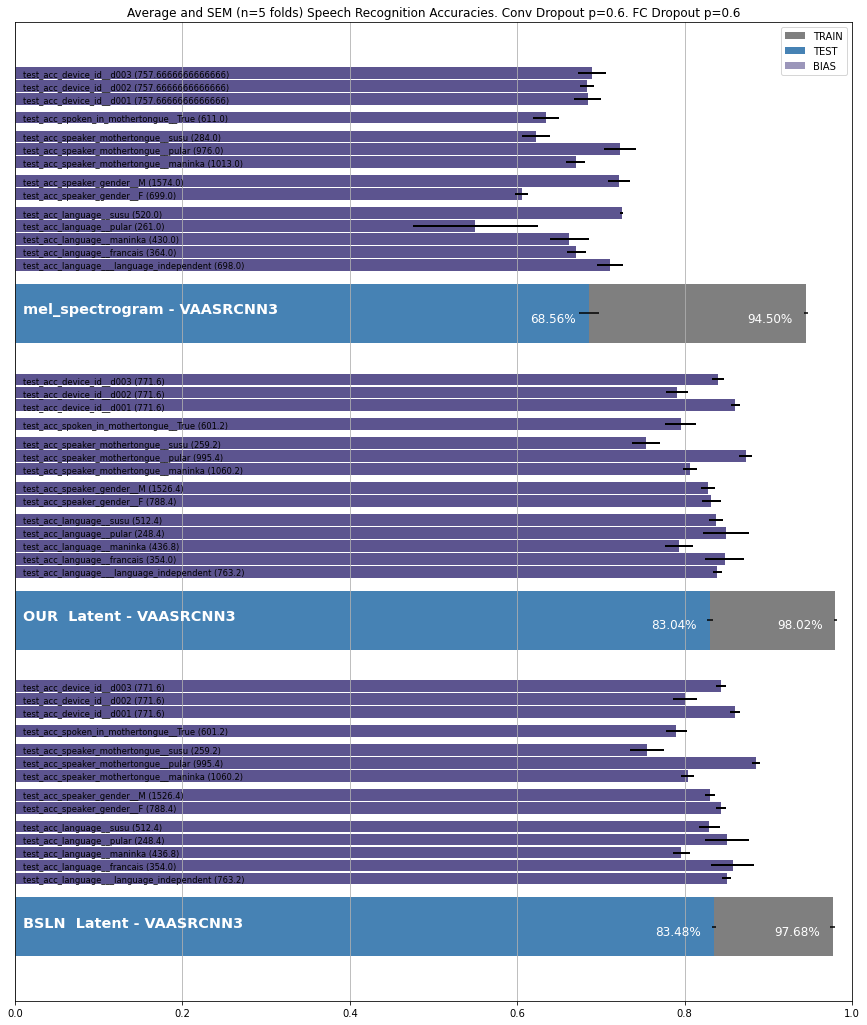

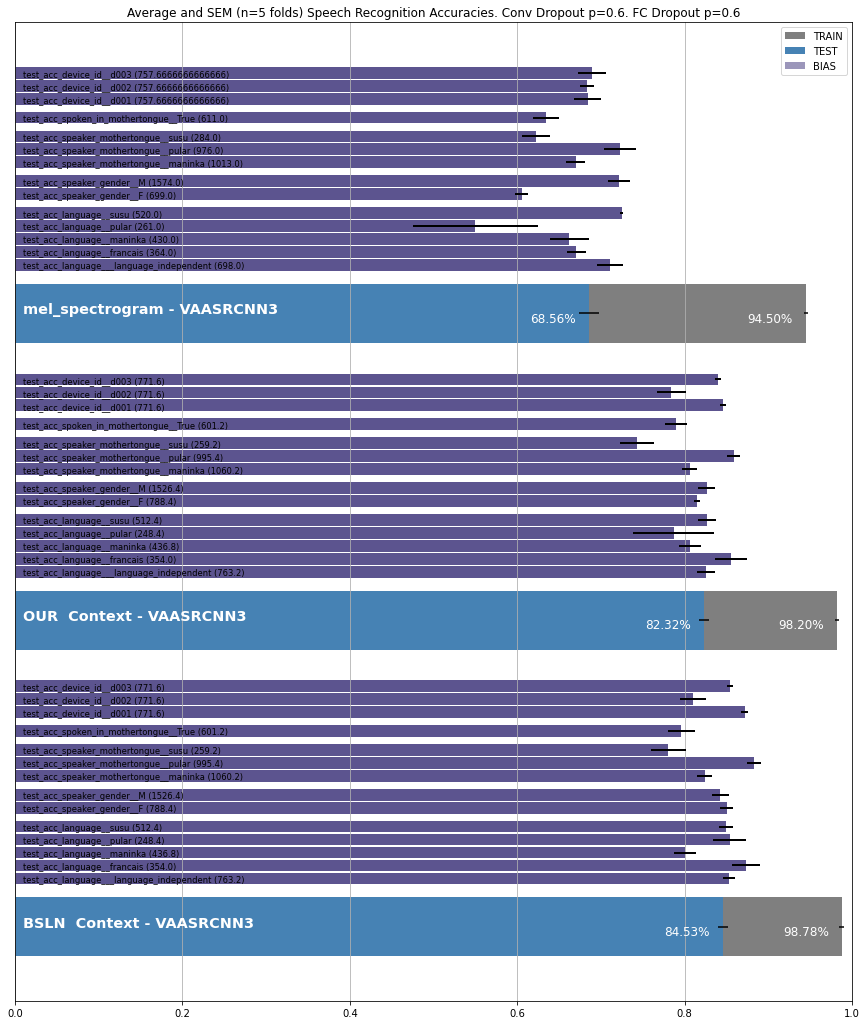

In [14]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z', 'mel_spectrogram']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c', 'mel_spectrogram']

for model_name in model_names:
    plot_summary_results([model_name], plotted_variables, compared_features_latent)
    plot_summary_results([model_name], plotted_variables, compared_features_ctx)
